This notebook provides statistics on the results of our book clustering.


## Setup


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Load Data

Let's start by getting our clusters and their statistics:


In [2]:
clusters = pd.read_parquet('book-links/cluster-stats.parquet')
clusters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40604472 entries, 0 to 40604471
Data columns (total 8 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   cluster        int32 
 1   n_nodes        uint32
 2   n_isbns        uint32
 3   n_loc_recs     uint32
 4   n_ol_editions  uint32
 5   n_ol_works     uint32
 6   n_gr_books     uint32
 7   n_gr_works     uint32
dtypes: int32(1), uint32(7)
memory usage: 1.2 GB


In [3]:
clusters.set_index('cluster', inplace=True)

Describe the count columns for basic descriptive stats:


In [4]:
clusters.describe()

,n_nodes,n_isbns,n_loc_recs,n_ol_editions,n_ol_works,n_gr_books,n_gr_works
count,4.060447e+07,4.060447e+07,4.060447e+07,4.060447e+07,4.060447e+07,4.060447e+07,4.060447e+07
mean,3.391963e+00,1.090844e+00,2.381654e-01,1.138889e+00,8.284441e-01,5.813781e-02,3.748262e-02
std,1.871179e+01,9.176982e+00,5.370353e-01,7.831073e+00,6.553446e-01,1.382494e+00,2.025173e-01
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
50%,3.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
75%,4.000000e+00,2.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
max,1.050550e+05,5.078500e+04,1.439000e+03,4.397000e+04,2.329000e+03,7.380000e+03,2.960000e+02


75% of clusters only contain 2 ISBNs (probably -10 and -13) and one book. OpenLibrary also contributes to the largest number of clusters.

## Clusters per Source

How many clusters are connected to each source?


In [5]:
src_counts = pd.Series(dict(
    (c, np.sum(clusters[c] > 0)) for c in clusters.columns
))
src_counts

n_nodes          40604472
n_isbns          23987846
n_loc_recs        9278233
n_ol_editions    34071860
n_ol_works       32228071
n_gr_books        1505252
n_gr_works        1504728
dtype: int64

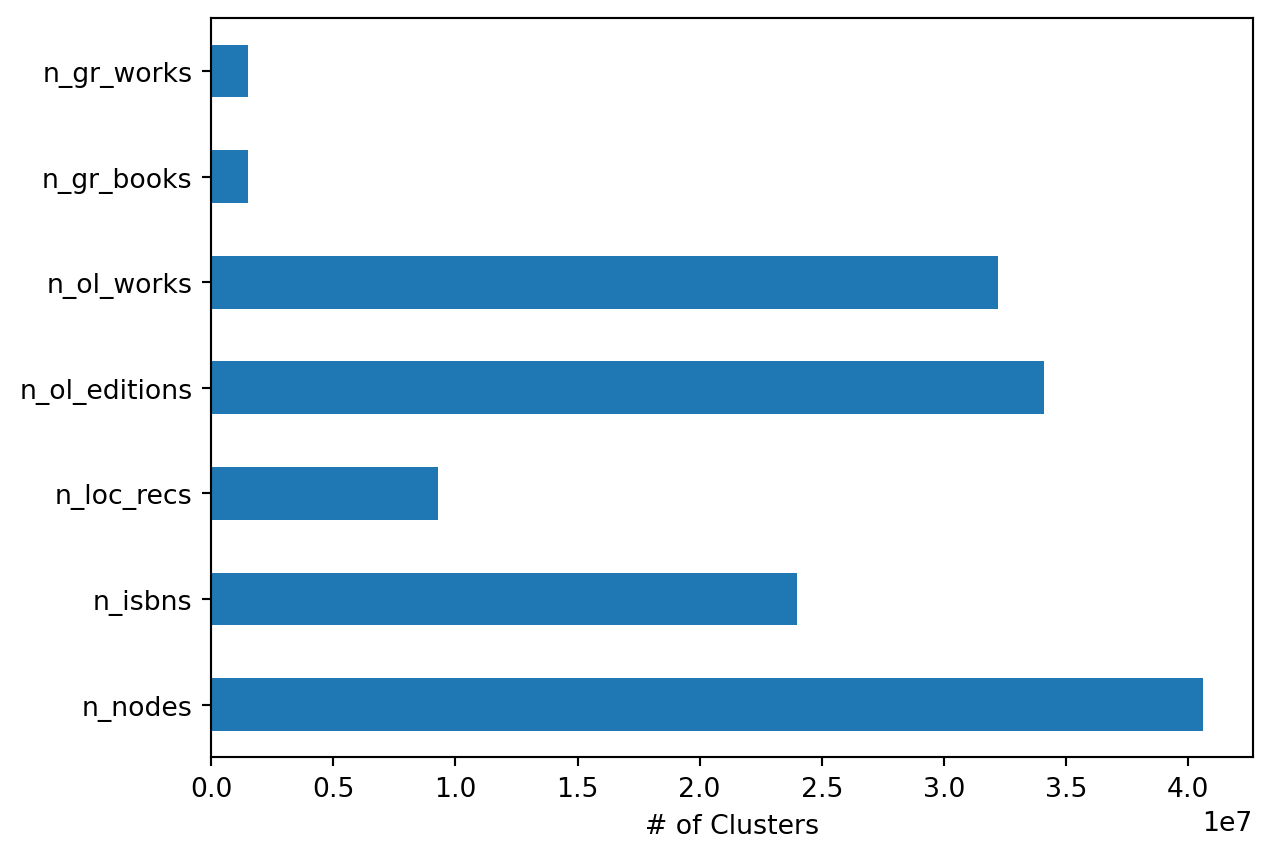

In [6]:
src_counts.plot.barh()
plt.xlabel('# of Clusters')
plt.show()

## Distributions

Let's look at the distributions of cluster sizes.


In [7]:
size_dist = pd.concat(dict(
    (c, clusters[c].value_counts()) for c in clusters.columns if c != 'n_nodes'
), names=['RecType'])
size_dist.index.set_names(['RecType', 'RecCount'], inplace=True)
size_dist = size_dist.reset_index(name='Clusters')
size_dist.head()

,RecType,RecCount,Clusters
0,n_isbns,0,16616626
1,n_isbns,1,12164026
2,n_isbns,2,9315867
3,n_isbns,4,847031
4,n_isbns,3,829375


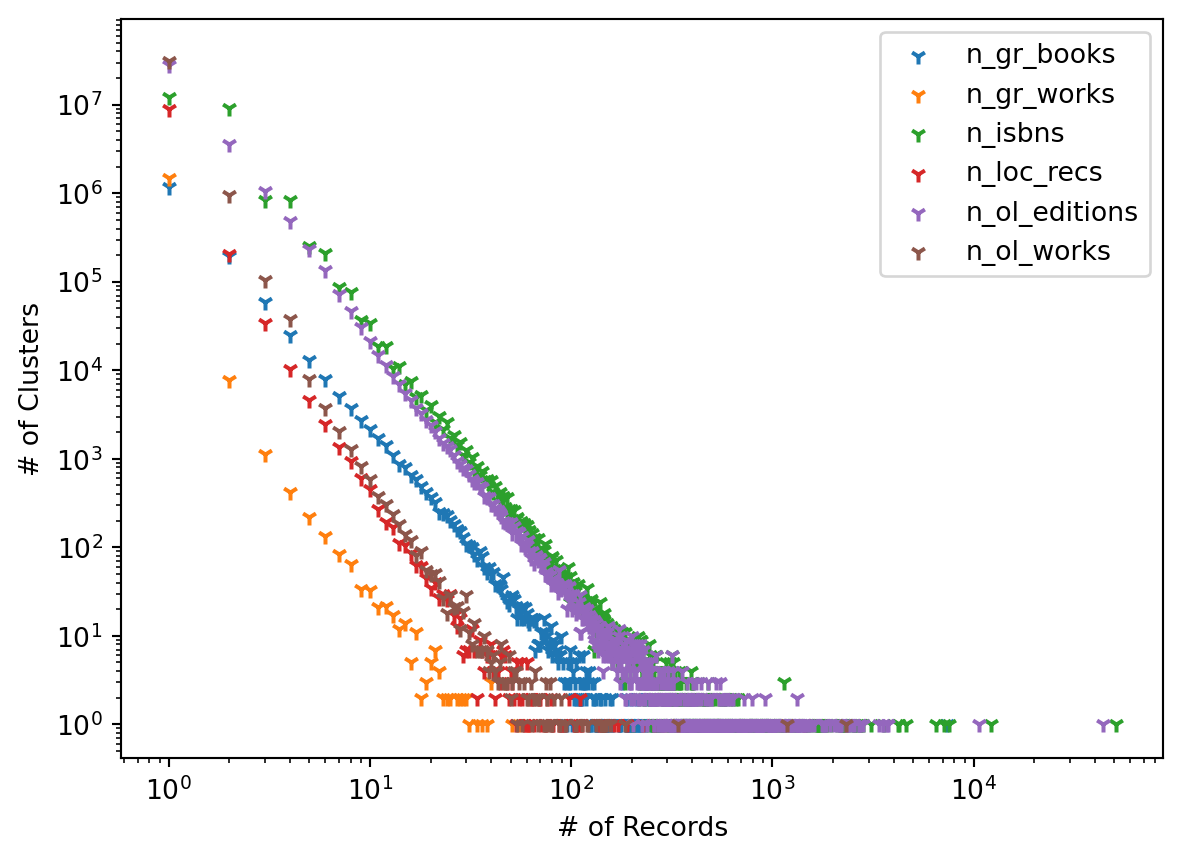

In [8]:
for rt, data in size_dist.groupby('RecType'):
    plt.scatter(data['RecCount'], data['Clusters'], marker='1', label=rt)
plt.legend()
plt.xlabel('# of Records')
plt.xscale('log')
plt.ylabel('# of Clusters')
plt.yscale('log')
plt.show()

Looks mostly fine - we expect a lot of power laws - but the number of clusters with merged GoodReads works is concerning.

## GoodReads Work Merging

Why are GoodReads works merging? Let's look at those.


In [9]:
gr_big = clusters[clusters['n_gr_works'] > 1].sort_values('n_gr_works', ascending=False)
gr_big.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10044 entries, 100059755 to 103303604
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   n_nodes        10044 non-null  uint32
 1   n_isbns        10044 non-null  uint32
 2   n_loc_recs     10044 non-null  uint32
 3   n_ol_editions  10044 non-null  uint32
 4   n_ol_works     10044 non-null  uint32
 5   n_gr_books     10044 non-null  uint32
 6   n_gr_works     10044 non-null  uint32
dtypes: uint32(7)
memory usage: 353.1 KB


We have a lot of these clusters. What fraction of the GoodReads-affected clusters is this?


In [10]:
len(gr_big) / clusters['n_gr_books'].count()

0.0002473619161948467

Less than 1%. Not bad, but let's look.


In [11]:
gr_big.head()

,n_nodes,n_isbns,n_loc_recs,n_ol_editions,n_ol_works,n_gr_books,n_gr_works
cluster,,,,,,,
100059755,105055,50785,1439,43970,1185,7380,296
100032170,9584,4624,281,3720,341,513,105
100156279,513,192,6,110,75,69,61
100124809,1602,780,55,462,78,172,55
100428296,315,141,1,51,18,53,51


## Large Cluster Debugging

We have some pretty big clusters:


In [12]:
big = clusters.nlargest(5, 'n_nodes')
big

,n_nodes,n_isbns,n_loc_recs,n_ol_editions,n_ol_works,n_gr_books,n_gr_works
cluster,,,,,,,
100059755,105055,50785,1439,43970,1185,7380,296
100510835,24374,12126,190,10610,68,1352,28
108162346,11281,7520,0,3760,1,0,0
102285712,10678,7118,0,3559,1,0,0
100148394,10118,6518,7,3558,35,0,0


What is up with this? We should figure out what went wrong, if we can.  What are its ISBNs?


In [13]:
isbns = pd.read_parquet('book-links/all-isbns.parquet').set_index('isbn_id')
isbns.head()

,isbn,LOC,OL,GR,BX,AZ14,AZ18
isbn_id,,,,,,,
1,1858338956,0,1,0,0,0,0
2,9789401010498,0,1,0,0,0,0
3,9788412175912,0,1,0,0,0,0
4,9781760893347,0,1,0,0,0,0
5,9780199192649,0,1,0,0,0,0


In [14]:
links = pd.read_parquet('book-links/isbn-clusters.parquet', columns=['isbn_id', 'cluster'])
links.head()

,isbn_id,cluster
0,44293137,944293137
1,44293136,944293136
2,44293135,944293135
3,44293134,944293134
4,44293133,944293133


In [15]:
big_id = big.index[0]
bl = links[links['cluster'] == big_id].drop(columns=['cluster'])
bl = bl.join(isbns, on='isbn_id')
bl.sort_values('isbn')

,isbn_id,isbn,LOC,OL,GR,BX,AZ14,AZ18
44259559,41743470,0000744395,0,0,1,0,0,0
44256080,41604450,000074445X,0,0,1,0,0,0
44291561,31743668,0001004735,0,1,0,0,0,0
44275398,13388484,0001004743,0,1,0,0,0,0
44275599,22829832,0001034375,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...
44269519,41059211,B073SM1DVP,0,0,1,0,0,0
44269959,41473054,B073SMQ7TV,0,0,1,0,0,0
44287211,41658035,B074P9CM5T,0,0,1,0,0,0
44249538,41290142,B074WFRH82,0,0,1,0,0,0


What are the things with the highest record count (besides ratings)?


In [16]:
bl['btot'] = bl.iloc[:, 2:-2].sum(axis=1)
bl.nlargest(20, 'btot')

,isbn_id,isbn,LOC,OL,GR,BX,AZ14,AZ18,btot
44247352,13097404,1559029838,0,15,1,180,0,0,196
44266424,7718222,0156628708,1,2,1,133,0,0,137
44262275,19649822,0553212583,0,2,1,84,0,0,87
44271809,36280777,0553210793,0,1,1,68,0,0,70
44252201,5498526,0140430016,0,1,1,58,0,0,60
44285698,15171570,0451523377,0,2,1,53,0,0,56
44262125,34090905,1853260010,0,3,1,51,0,0,55
44242997,20997858,006440188X,0,2,1,50,549,0,53
44267267,39381800,0156907399,0,2,1,48,0,0,51
44252249,11828673,0140620125,0,1,1,39,26,0,41
